### 6. juli

Starten av dagen gikk til å koble seg til tungregningsmaskinene og få lastet opp filene mine på Jupyter. Fikk hjelp av noen på seksjonen slik at dette ble fikset. Hjalp deretter en annen med å koble seg på.

Kjørte så double descent scriptet fra 29_06_23.ipynb noe som fremdeles tok lang tid. Halvveis inn ble kjøringen stoppet så måtte starte på nytt. Tok derfor ekstra lang tid. Da koden endelig var ferdig med å kjøre før jeg gikk hjem, fikk jeg dessverre ikke noe double descent kurve :( Det kan være siden nettverket jeg brukte i koden var et vanlig MLP-nettverk og ikke CNN.

Siden jeg fikk vite at hovedmålet med prosjektet er å se på vektendringen, slik at double descent kurvene ikke er like relevante gikk jeg over koden jeg har til nå og skrev mer utfyllende om de ulike vektendringene jeg har studert. 

Så på det jeg gjorde sist i 01-04_07_23.ipynb og prøver nå å plotte alle vektendringene, også de negative. Fant ut av hvorfor sannsynlighetstettheten min ble rar. Viste seg at jeg ikke hadde forstått ordentlig hva density=True i plt.hist gjør. For å finne sannsynlighetstettheten i hvert punkt kan jeg bare hente ut denne fra plt.hist. Får samme resultat om jeg bruker koden jeg har men endrer til density=False i np.histogram for da blir sannsynlighetstettheten regnet ut riktig.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [3]:
# Hyperparameters
input_dim = 28**2  # MNIST images are 28x28 pixels
hidden_dim1 = 128  # Number of units in the first hidden layer
hidden_dim2 = 100  # Number of units in the second hidden layer
learning_rate = 0.01
output_dim = 10  # Initial output classes 
batch_size = 64


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        self.R = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.R(self.layer1(x))
        x = self.R(self.layer2(x))
        x = self.layer3(x)
        return x

In [5]:
# Normalizes the data like I did earlier by dividing by 255.0
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Create an instance of the network
model = Net()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
# Set random seed for reproducibility
torch.manual_seed(43)

num_epochs = 2
# Track the weight differences
weight_differences = []
# Variables to store the initial and final weights
initial_weights = []
final_weights = []

# Training loop
for epoch in trange(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the weights after the desired epochs
    if epoch == 0:
        initial_weights = model.layer1.weight.data.clone()
    elif epoch == num_epochs - 1:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = (final_weights - initial_weights)
        weight_differences.extend(weight_diff.view(-1).detach().numpy())

    print(f"Epoch [{epoch}/{num_epochs}]")


  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:30<00:30, 30.05s/it]

Epoch [0/2]


100%|██████████| 2/2 [00:56<00:00, 28.41s/it]

Epoch [1/2]


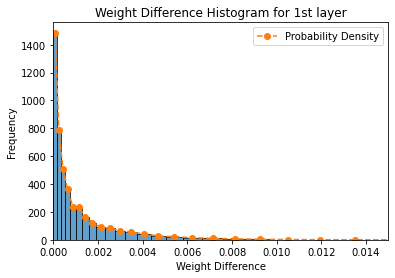

In [49]:
# Define the number of bins and the scaling factor for increasing bin widths
num_bins = 25
bin_width_scale = 15

# Calculate the scaling factor for each bin
bin_scaling = np.exp(np.linspace(0, np.log(bin_width_scale), num_bins))

# Insert 0 as the first element of bin_scaling so that the first edge starts at 0
bin_scaling = np.insert(bin_scaling, 0, 0)

# Calculate the bin edges
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences)

# Plot the histogram with custom bin widths
plt.hist(weight_differences, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram for 1st layer")

# Calculate probability density
hist, _ = np.histogram(weight_differences, bins=bin_edges, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)
prob_density = hist / (np.sum(hist) * bin_widths)

# Plot probability density curve
plt.plot(bin_centers, prob_density, "o--", label="Probability Density")
plt.legend()
plt.xlim(0, 0.015)
plt.show()

Slik blir den riktige sannsynlighetstettheten. Prøver nå å gjøre det samme for både de negative og positive vektendringene. Plotter først vektendringene med samme bin-bredde for å se omtrent hvordan fordelingen ser ut.

Text(0.5, 1.0, 'Weight Difference Histogram for 1st layer')

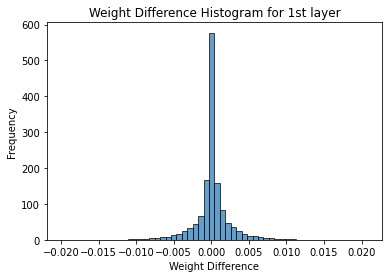

In [105]:
# Plot the histogram
plt.hist(weight_differences, bins=56, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram for 1st layer")

[-15.         -13.88317032 -12.84949454 -11.89278142 -11.00730067
 -10.18774866  -9.42921666  -8.72716139  -8.07737786  -7.47597417
  -6.91934818  -6.40416596  -5.92734178  -5.4860197   -5.07755639
  -4.69950535  -4.34960221  -4.02575122  -3.72601266  -3.44859122
  -3.19182529  -2.95417694  -2.73422277  -2.53064536  -2.34222537
  -2.16783425  -2.00642748  -1.85703829  -1.71877193  -1.59080023
  -1.4723567   -1.36273192  -1.26126929  -1.16736109  -1.08044486
  -1.           1.           1.08044486   1.16736109   1.26126929
   1.36273192   1.4723567    1.59080023   1.71877193   1.85703829
   2.00642748   2.16783425   2.34222537   2.53064536   2.73422277
   2.95417694   3.19182529   3.44859122   3.72601266   4.02575122
   4.34960221   4.69950535   5.07755639   5.4860197    5.92734178
   6.40416596   6.91934818   7.47597417   8.07737786   8.72716139
   9.42921666  10.18774866  11.00730067  11.89278142  12.84949454
  13.88317032  15.        ]


ValueError: `bins` must increase monotonically, when an array

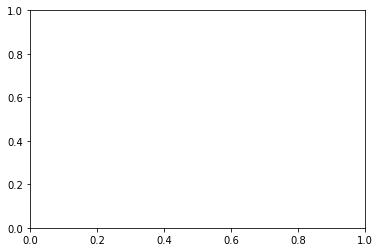

In [104]:
# Define the number of bins and the scaling factor for increasing bin widths
num_bins = 36
bin_width_scale = 15

# Calculate the scaling factor for each bin
bin_scaling_positive = np.exp(np.linspace(0, np.log(bin_width_scale), num_bins))
bin_scaling_negative = -np.exp(np.linspace(np.log(bin_width_scale), 0, num_bins))

# Combine the scaling factors for negative and positive weight changes
bin_scaling = np.concatenate((bin_scaling_negative, bin_scaling_positive))

bin_edges = np.cumsum(bin_scaling)
print(bin_edges)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences)

# Calculate the bin edges
start = np.min(weight_differences)
end = np.max(weight_differences)
#bin_edges = np.linspace(start, end, num_bins + 1)

# Plot the histogram with custom bin widths
plt.hist(weight_differences, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency / Probability Density")
plt.title("Weight Differences between epoch 0-1 for layer 1")

# Calculate probability density
hist, _ = np.histogram(weight_differences, bins=bin_edges, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)
prob_density = hist / (np.sum(hist) * bin_widths)

# Plot probability density curve
plt.plot(bin_centers, prob_density, "o--", label="Probability Density")
plt.legend()
plt.xlim(-0.01, 0.01)
plt.show()


Siden vektendringene er nokså normalfordelt rundt 0 nøyer jeg meg med å kun se på absoluttverdien av vektendringene slik jeg har gjort i 01-04_07_23.ipynb.